In [1]:
from keras.layers import Input,Dense,Flatten
from keras.models import Model

# getting the pretrained model 
from keras.applications.vgg16 import VGG16,preprocess_input  #xception 

from keras.preprocessing import image 
from keras.preprocessing.image import ImageDataGenerator
from keras import utils
from keras.optimizers import Adam

from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from glob import glob

from skimage.transform import resize 

from imageio import imread

In [3]:
ch=imread('charmander-tight.png')

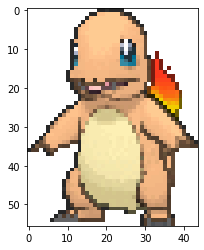

In [4]:
plt.imshow(ch)

In [5]:
ch.shape

(56, 44, 4)

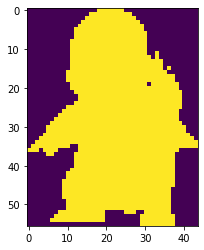

In [6]:
plt.imshow(ch[:,:,3])
plt.show()

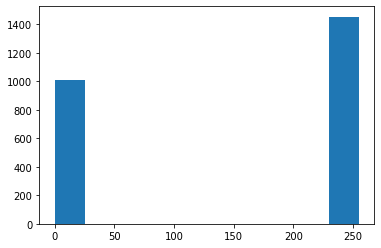

In [7]:
plt.hist(ch[:,:,3].flatten())
plt.show()

In [8]:
poke_dim=200
ch=np.array(ch)
ch_h,ch_w,_=ch.shape


def image_generator(batch_size=64):
  while True:
    for _ in range(50):#50 batches per epoch 
      X=np.zeros((batch_size,poke_dim,poke_dim,3))
      Y=np.zeros((batch_size,4))

      for i in range(batch_size):
        row0=np.random.randint(poke_dim-ch_h)
        col0=np.random.randint(poke_dim-ch_w)
        row1=row0+ch_h
        col1=col0+ch_w
        
        #maybe flip 
        if np.random.random()<0.5:
          obj = np.fliplr(ch)
        else:
          obj=ch

        X[i,row0:row1,col0:col1,:]=obj[:,:,:3]

        Y[i,0]=row0/poke_dim
        Y[i,1]=col0/poke_dim
        Y[i,2]=(row1-row0)/poke_dim
        Y[i,3]=(col1-col0)/poke_dim
      
      yield X/255.,Y



In [9]:
vgg=VGG16(input_shape=[poke_dim,poke_dim,3],weights='imagenet',include_top=False)
x=Flatten()(vgg.output)
x=Dense(4,activation='sigmoid')(x) 

model=Model(vgg.input,x)
model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                              

In [10]:
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.0001))

In [11]:
hist=model.fit(image_generator(),steps_per_epoch=50,epochs=2,verbose=1)

Epoch 1/2
50/50 [==============================] - 54s 666ms/step - loss: 0.5637
Epoch 2/2
50/50 [==============================] - 34s 684ms/step - loss: 0.5531


In [12]:
def make_pred():

  #maybe flip 
  if np.random.random()<0.5:
    obj = np.fliplr(ch)
  else:
    obj=ch


  x=np.zeros((poke_dim,poke_dim,3))
  row0=np.random.randint(poke_dim-ch_h)
  col0=np.random.randint(poke_dim-ch_w)
  row1=row0+ch_h
  col1=col0+ch_w

  x[row0:row1,col0:col1,:]=obj[:,:,:3]

  print(row0,col0,row1,col1)

  X=np.expand_dims(x,0)/255.
  p=model.predict(X)[0]

  fig,ax=plt.subplots(1)
  ax.imshow(x.astype(np.uint8))
  rect=Rectangle(
      (p[1]*poke_dim,p[0]*poke_dim),
      p[3]*poke_dim,p[2]*poke_dim,
      linewidth=1,
      edgecolor='r',
      facecolor='none'
  )
  ax.add_patch(rect)
  plt.show()



26 23 82 67
1/1 [==============================] - 0s 18ms/step


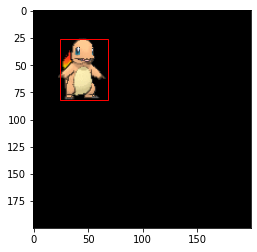

In [16]:
make_pred()